In [39]:
# Import libraries

# Data processing and manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.cluster import KMeans
import scipy.stats as stats

import xgboost as xgb

# Other
import importlib
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
import inferenceModels as im
import preprocess_data as ppd
import mutual_information as mi



# Mutual information
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif



from typing import Iterable
from pathlib import Path

from sklearn.metrics import mutual_info_score



importlib.reload(im)
importlib.reload(ppd)
importlib.reload(mi)

<module 'mutual_information' from '/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/mutual_information.py'>

In [5]:
def load_feature_bases(weather_path: Path, powerload_path: Path) -> list[str]:
    weather = pd.read_csv(weather_path, parse_dates=["datetime"])
    power =  pd.read_csv(powerload_path, parse_dates=["UTC time"])
    base = list(weather.columns) + list(power.columns) #+ ['Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']#, 'Technology']

    # Remove duplicates but keep stable order
    seen = set()
    base = [c for c in base if not (c in seen or seen.add(c))]
    # Drop known non-features if present
    drop = {'datetime', 'UTC time', 'Datetime_UTC', 'Datetime'}
    feats = [c for c in base if c not in drop]
    feats = list(set([(name[0].upper() + name[1:]) if isinstance(name, str) and name else name for name in feats]))
    feats.sort()
    return feats

technology_groups = {'nuclear': ['Nuclear'],
                    'hydro': ['Pumped Storage/Hydro'],
                    'geothermal': ['Geothermal'],
                    'thermal': ['CC GT units ', 
                                'CC steam units', 
                                'Co-generator Block ', 
                                'CoG GT units', 
                                'CoG steam units ', 
                                'Combined Cycle Block', 
                                'Fluidized Bed', 'Fossil-Steam', 
                                'Gas Turbine/Jet Engine (Simple Cycle Operation)', 
                                'Gas Turbine/Jet Engine with HSRG', 
                                'Internal Combustion/Reciprocating Engines',
                                'Multi-boiler/Multi-turbine']}

In [42]:
weather_data_file = "../Data/hourly/hourly_weather_by_state.csv"
power_load_file = "../Data/hourly/hourly_load_by_state.csv"
failure_data_file = "../Data/hourly/hourly_failure_dataset_compressed.csv"

feature_names_base = load_feature_bases(weather_data_file, power_load_file)
# feature_names_base = ['Temperature']
print(f"{len(feature_names_base)} initial features: {feature_names_base}")

# test_periods = [(pd.Timestamp('2022-01-01'), pd.Timestamp('2023-12-31'))]
techno = 'thermal'
# technologies = technology_groups[techno]

technologies = ['Gas Turbine/Jet Engine (Simple Cycle Operation)']
initial_state = 'all'
state = 'all'
if 'State' in feature_names_base:
    # feature_names_base.remove('State')
    print("State found in feature names base")




train_df, test_df, feature_names, target_columns, integer_encoding = ppd.preprocess_data(failure_data_path=failure_data_file,
                                                                                weather_data_path=weather_data_file,
                                                                                power_load_data_path=power_load_file,
                                                                                feature_names=feature_names_base,
                                                                                cyclic_features=["Season", "Month", "DayOfWeek", "DayOfYear"],
                                                                                state_one_hot=False,
                                                                                initial_MC_state_filter=initial_state,
                                                                                technology_filter=technologies,
                                                                                state_filter=state
                                                                                )


# Standardize all continuous features (exclude one-hots and raw categorical/cyclic markers)
exclude = {"Holiday", "Weekend", "Season", "Month", "DayOfWeek", "DayOfYear"}
stand_cols = [f for f in feature_names if not f.startswith("State_") and not f.startswith("Technology_") and not f.endswith("_isnan") and not f.endswith("_sin") and not f.endswith("_cos") and f not in exclude]
print(f"Standardized features ({len(stand_cols)}): {stand_cols}")

feature_names.sort()
stand_cols.sort()
target_columns.sort()

print(f"Encoding for 'Final_gen_state': {integer_encoding['Final_gen_state']}")

32 initial features: ['1d_load_sum', '24h_max_load', '24h_min_load', '2d_load_sum', 'CDD', 'CDD3d', 'Dew_point_temperature', 'Extreme_cold', 'Extreme_heat', 'FDD', 'FDD3d', 'HDD', 'HDD3d', 'Heat_index', 'Hourly_load_change', 'Load', 'Precip_1d', 'Precip_3d', 'Precipitation', 'Pressure_3hr_change', 'Relative_humidity', 'Sea_level_pressure', 'Snow_depth', 'State', 'Station_level_pressure', 'Temperature', 'Tmax', 'Tmean', 'Tmin', 'Wet_bulb_temperature', 'Wind_chill', 'Wind_speed']
State found in feature names base
                      Datetime_UTC Initial_gen_state Final_gen_state  \
2        2013-01-01 04:00:00+00:00                 A               A   
7        2013-01-01 04:00:00+00:00                 A               A   
13       2013-01-01 05:00:00+00:00                 A               A   
22       2013-01-01 05:00:00+00:00                 A               A   
31       2013-01-01 05:00:00+00:00                 A               A   
...                            ...               ..

In [4]:
full_df = []
for _, row in train_df.iterrows():
    full_df.append(row.repeat(int(row.Data_weight)))
full_df = pd.concat(full_df)

In [47]:
feature_names# 'Heat_index', 
mutual_info_features = ['Dew_point_temperature', 'Load',  'Precipitation', 'Pressure_3hr_change', 'Relative_humidity', 'Sea_level_pressure', 'Snow_depth', 'Station_level_pressure', 'Temperature',  'Wet_bulb_temperature', 'Wind_chill', 'Wind_speed']

In [48]:
mi_df = mi.compute_mutual_information_auto(
    df=train_df,
    library='npeet',                  # 'npeet' or 'sklearn'
    feature_names=mutual_info_features,
    target_col=target_columns[0],                     # or your other target
    discrete_features=[],  # your explicit list (best source of truth)
    k=5,                                  # match sklearn's n_neighbors for fairer comparison
    out_csv='out_csv_file.csv',
    standardize_continuous=False,         # set True if scales vary a lot
)

Saved MI ranking to out_csv_file.csv


In [49]:
mi_df

,feature,mi
0,Pressure_3hr_change,0.304573
1,Load,0.290552
2,Relative_humidity,0.266637
3,Sea_level_pressure,0.236550
4,Wind_speed,0.229699
5,Precipitation,0.123999
6,Station_level_pressure,0.073679
7,Wet_bulb_temperature,0.031177
8,Dew_point_temperature,0.020773
9,Wind_chill,0.010776


In [42]:
from npeet import entropy_estimators as ee

In [77]:
id2state

{0: 'A', 1: 'D', 2: 'U'}

In [25]:
id2state = {v:k for k,v in integer_encoding['Final_gen_state'].items()}

In [31]:
def plot_state_transition_vs_feature(train_df: pd.DataFrame, feature: str, x_multiplicator: float=1.0):
    fig, axs = plt.subplots(3, 3, figsize=(9, 9))
    for initial_state_idx, initial_state in enumerate([0, 1, 2]):
        subset_df = train_df.loc[train_df['Initial_gen_state']==initial_state]
        a = subset_df.groupby(['Datetime_UTC', 'Final_gen_state', feature]).agg({'Data_weight':'sum'}).reset_index()
        b = subset_df.groupby(['Datetime_UTC']).agg({'Data_weight':'sum', feature:'first'})
        count = a.join(b, how='left', on='Datetime_UTC', lsuffix='_final', rsuffix='_total')
        count['Freq'] = count['Data_weight_final'] / count['Data_weight_total']

        for final_state_idx, final_state in enumerate([0,1,2]):
            x =count.loc[count['Final_gen_state']==final_state, feature+'_final'].values
            y = count.loc[count['Final_gen_state']==final_state, 'Freq'].values
            w = count.loc[count['Final_gen_state']==final_state, 'Data_weight_final'].values
            x_plot = np.linspace(x.min(), x.max(), 100)
            x_delta = (x_plot[1]-x_plot[0])
            y_mean = []
            y_median = []
            for x_val in x_plot:
                mask = (x >= x_val - x_delta) & (x <= x_val + x_delta)
                if np.sum(mask) > 0:
                    y_mean.append(np.average(y[mask], weights=w[mask]))
                    ym = np.median(np.repeat(y[mask], w[mask].astype(int)))
                    y_median.append(ym)
                else:
                    y_mean.append(0)
                    y_median.append(0)


            max_w = count['Data_weight_total'].max()
            w = w/max_w
            w = 0.3+ 0.7*w

            ax = axs[initial_state_idx, final_state_idx]
            # ax.scatter(x*x_multiplicator, y, alpha=w)
            ax.plot(x_plot*x_multiplicator, y_mean, color='red')
            ax.plot(x_plot*x_multiplicator, y_median, color='orange')
            ax.set_title(f'{id2state[initial_state]} -> {id2state[final_state]}')
            ax.set_xlabel(feature)
            ax.set_ylabel('Frequency')
    legend_handles = [Line2D([0], [0], color='red', lw=2),
                        Line2D([0], [0], color='orange', lw=2)]
    fig.legend(legend_handles, ['Mean', 'Median'], loc='upper right', fontsize='medium')
    plt.suptitle(f'Generator state transitions vs {feature}')
    plt.tight_layout()

In [37]:
print(feature_names)

['1d_load_sum', '24h_max_load', '24h_min_load', '2d_load_sum', 'CDD', 'CDD3d', 'Dew_point_temperature', 'Extreme_cold', 'Extreme_heat', 'FDD', 'FDD3d', 'HDD', 'HDD3d', 'Heat_index', 'Heat_index_isnan', 'Hourly_load_change', 'Initial_gen_state', 'Load', 'Precip_1d', 'Precip_3d', 'Precipitation', 'Pressure_3hr_change', 'Relative_humidity', 'Sea_level_pressure', 'Snow_depth', 'Station_level_pressure', 'Temperature', 'Tmax', 'Tmean', 'Tmin', 'Wet_bulb_temperature', 'Wind_chill', 'Wind_chill_isnan', 'Wind_speed']


In [38]:
features_plot = [ 'Temperature', 'Tmax', 'Tmean', 'Tmin', 'Heat_index', 'Dew_point_temperature',   'Precipitation',  'Relative_humidity', 'Sea_level_pressure', 'Snow_depth',  'Wind_chill',  'Wind_speed','Load', 'Hourly_load_change']

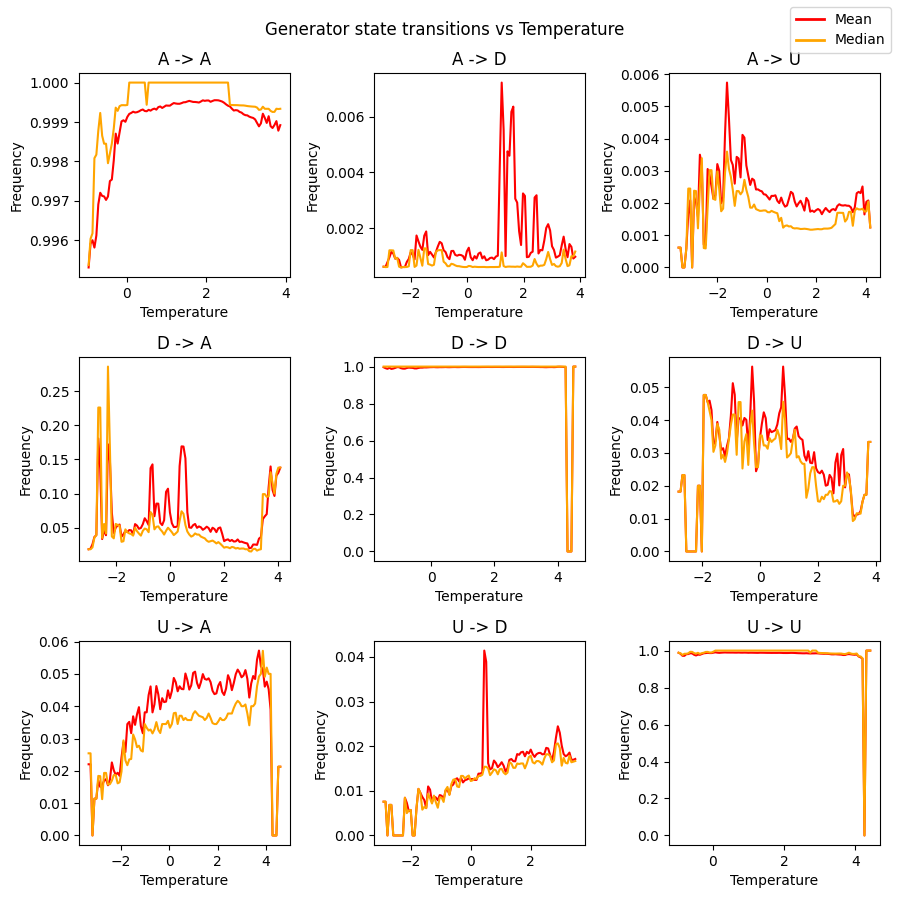

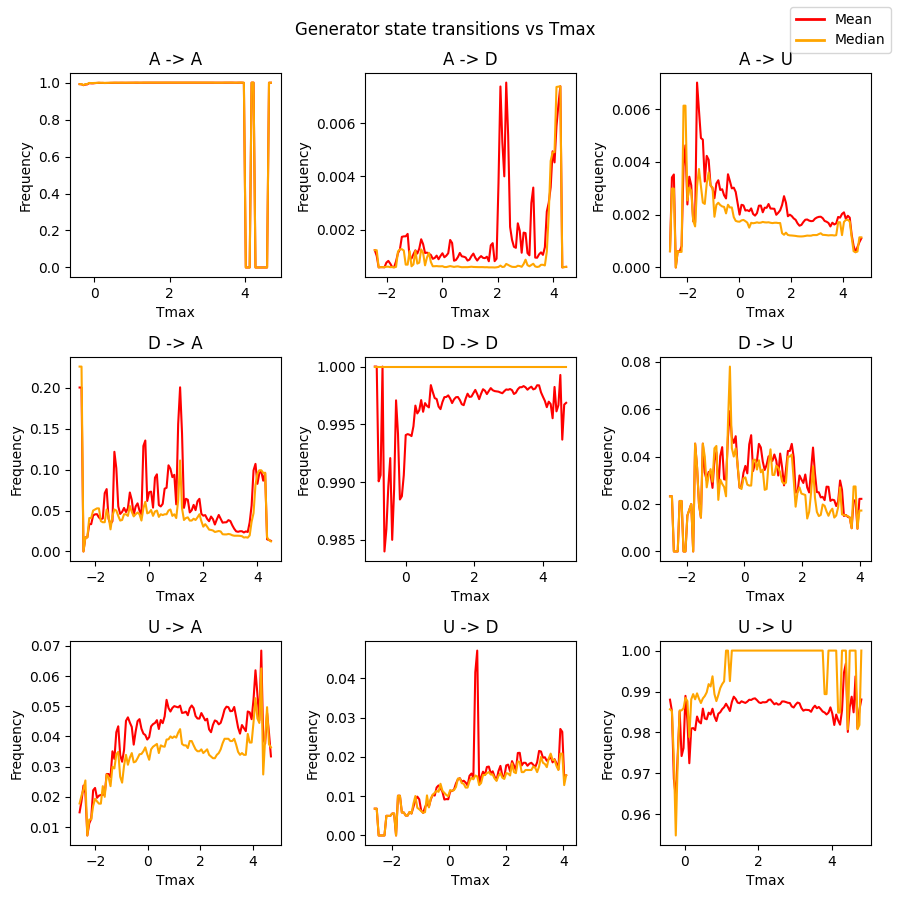

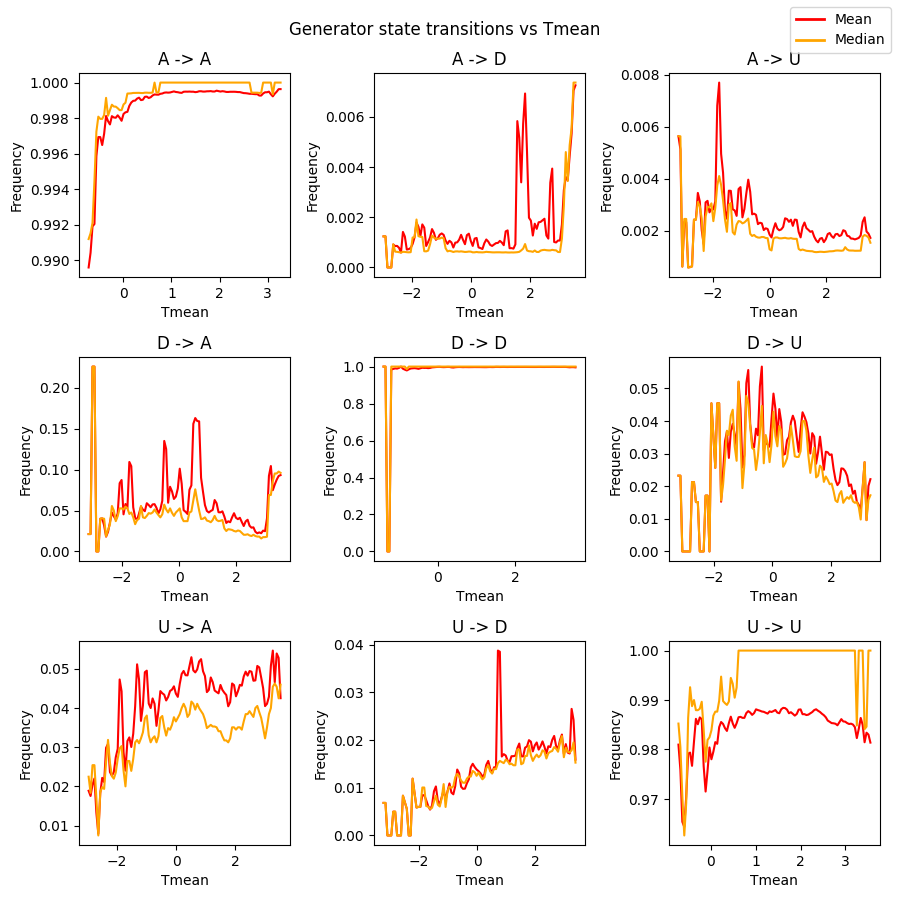

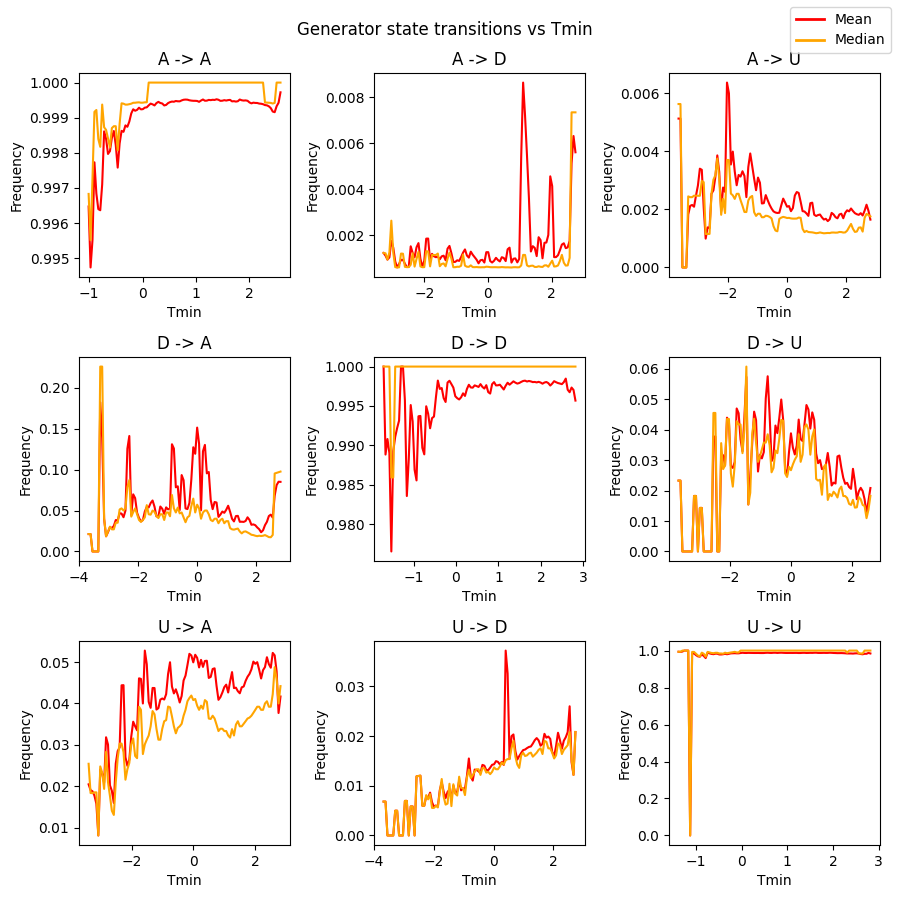

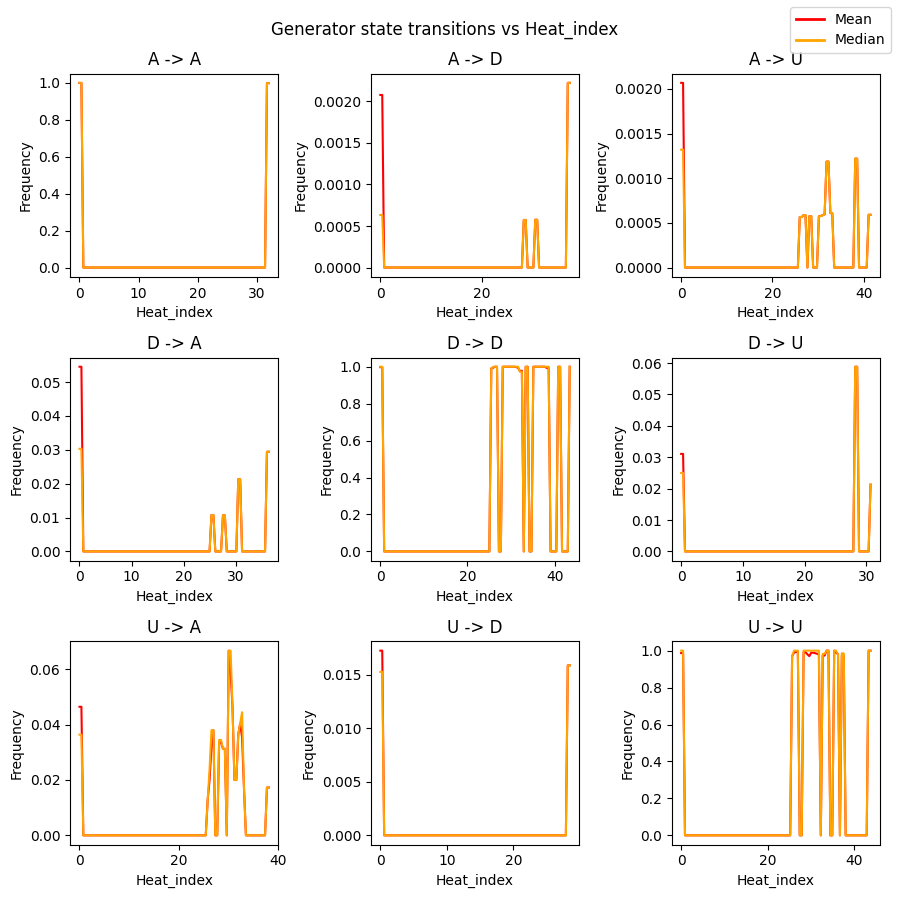

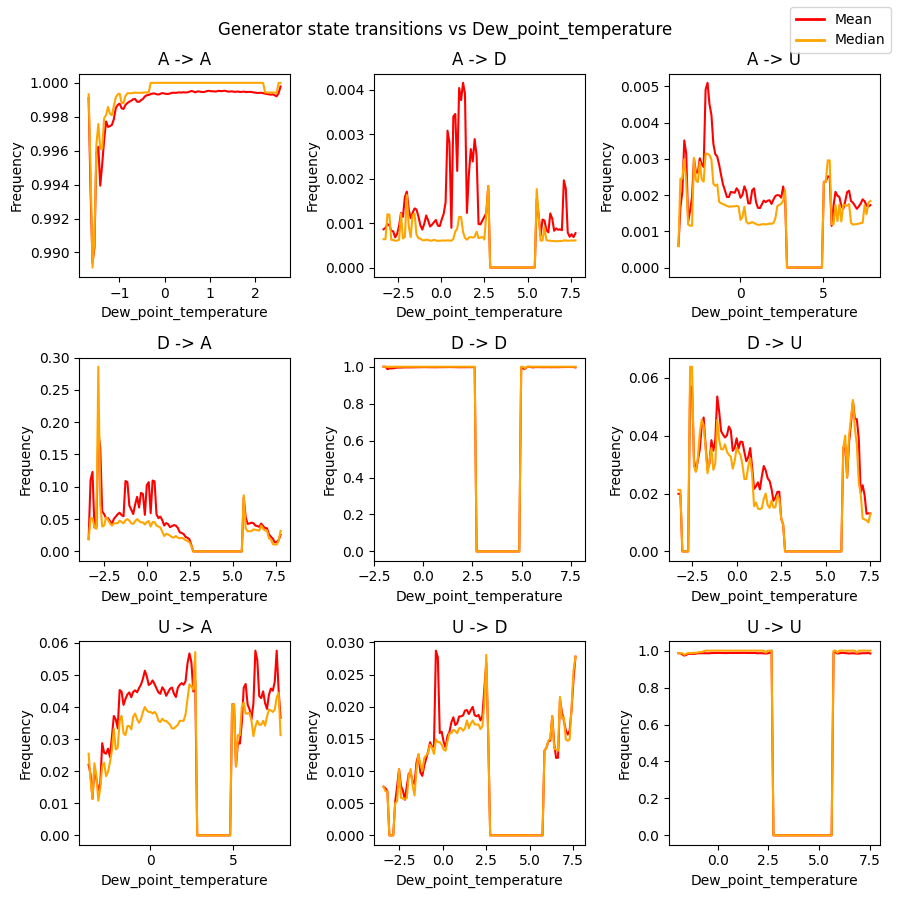

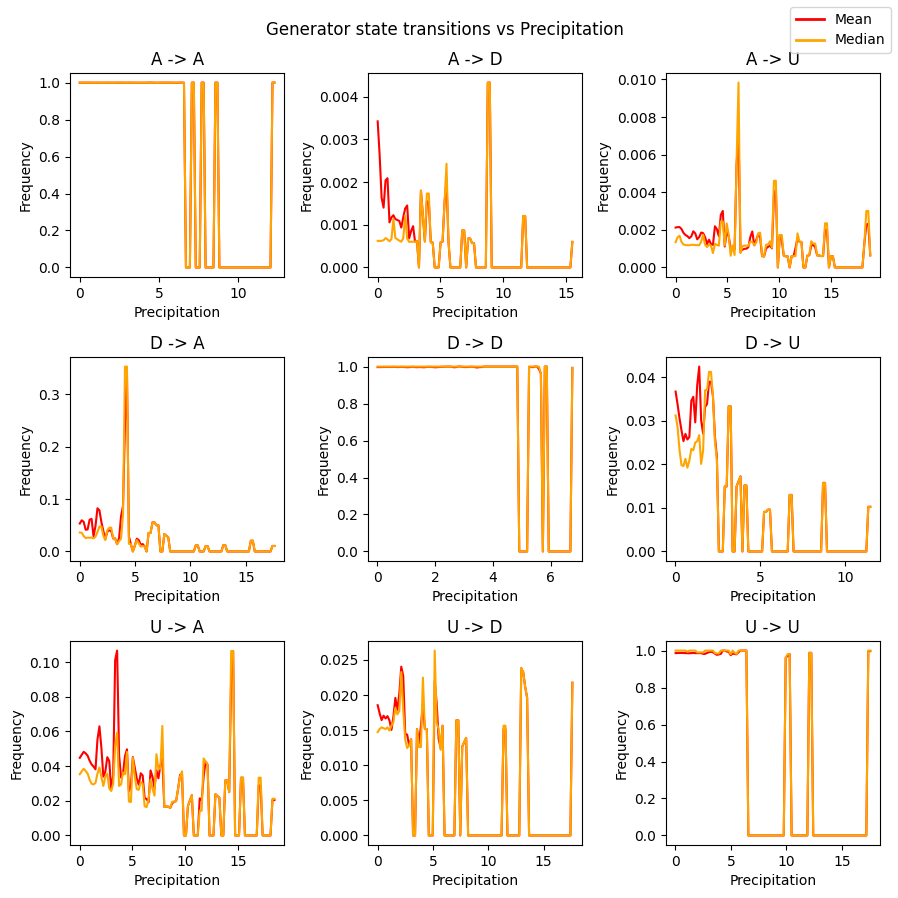

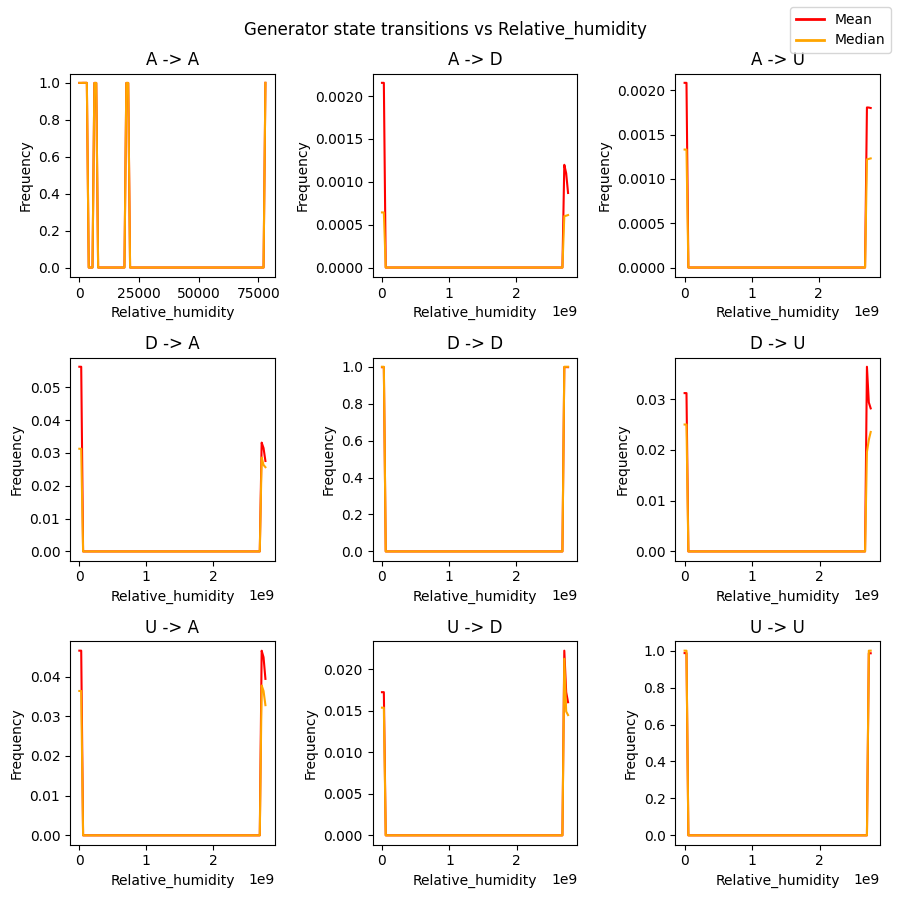

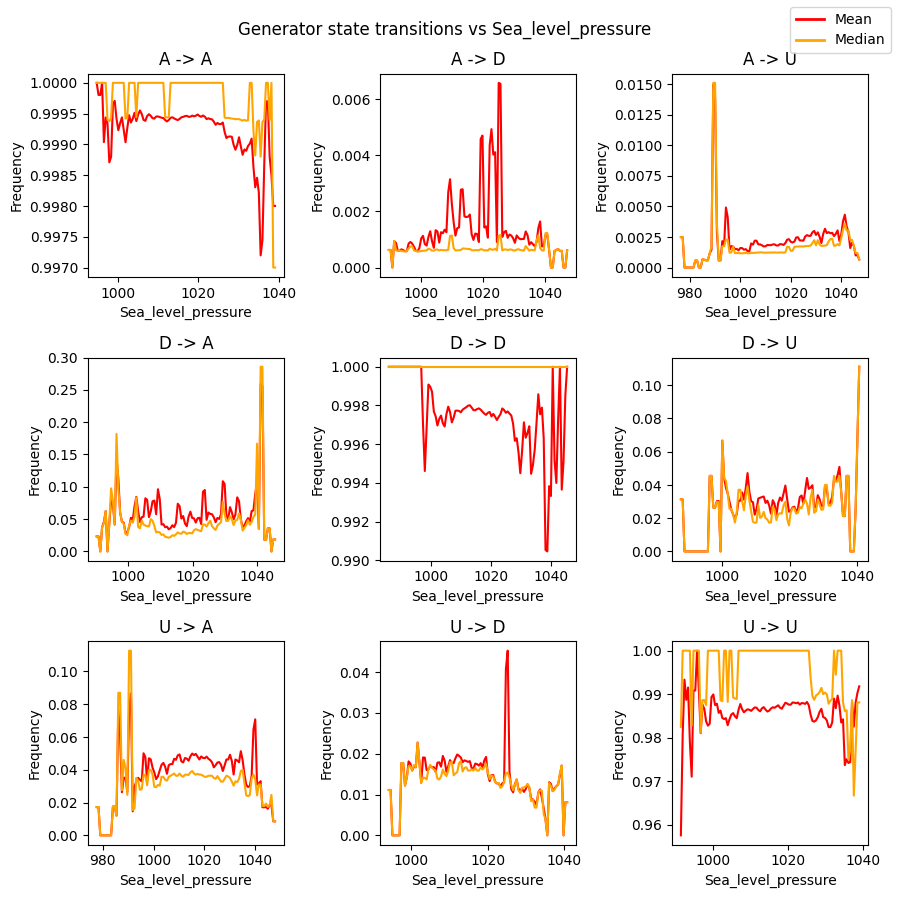

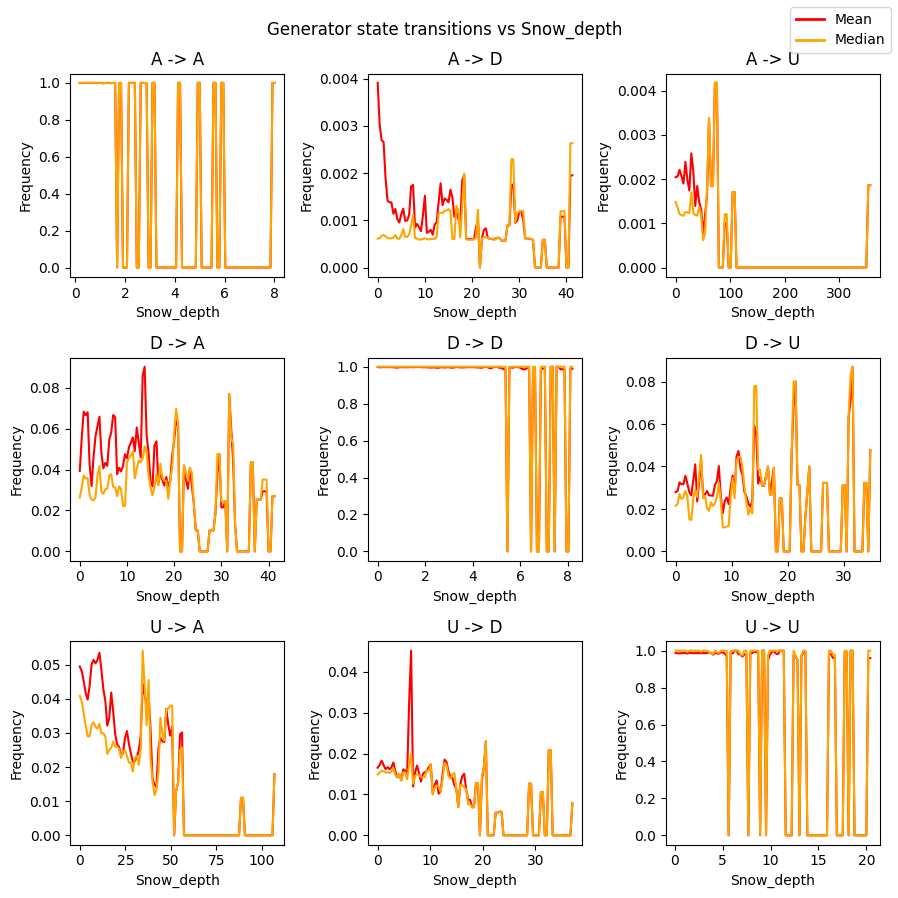

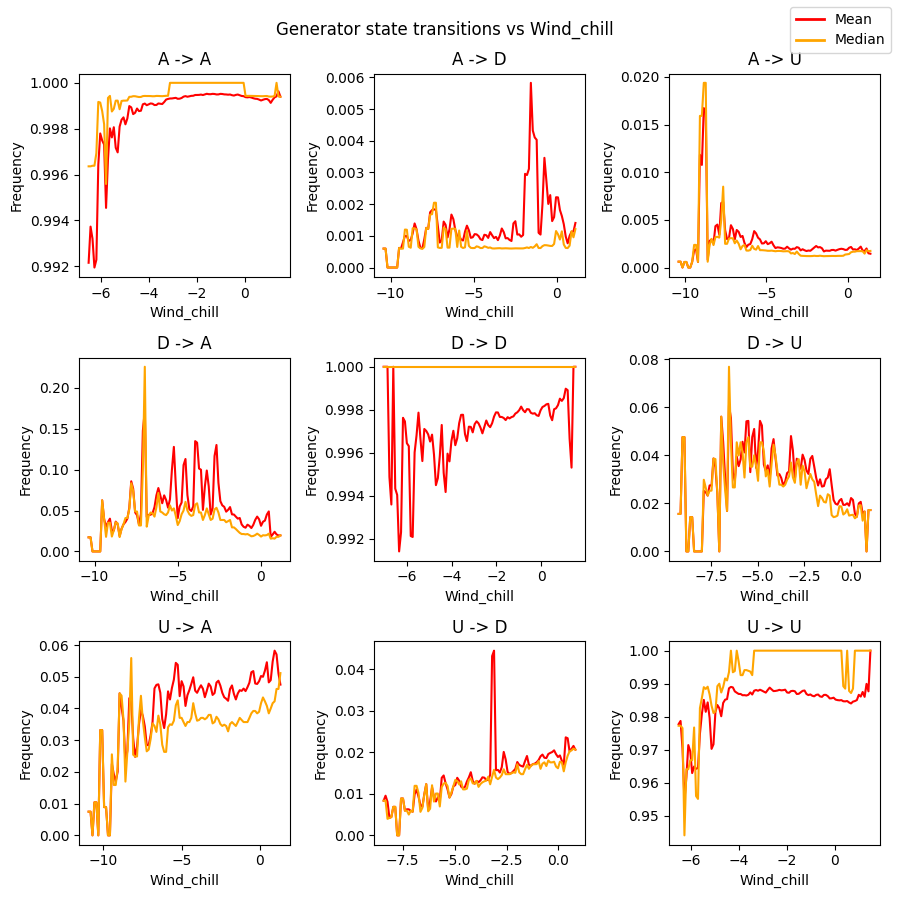

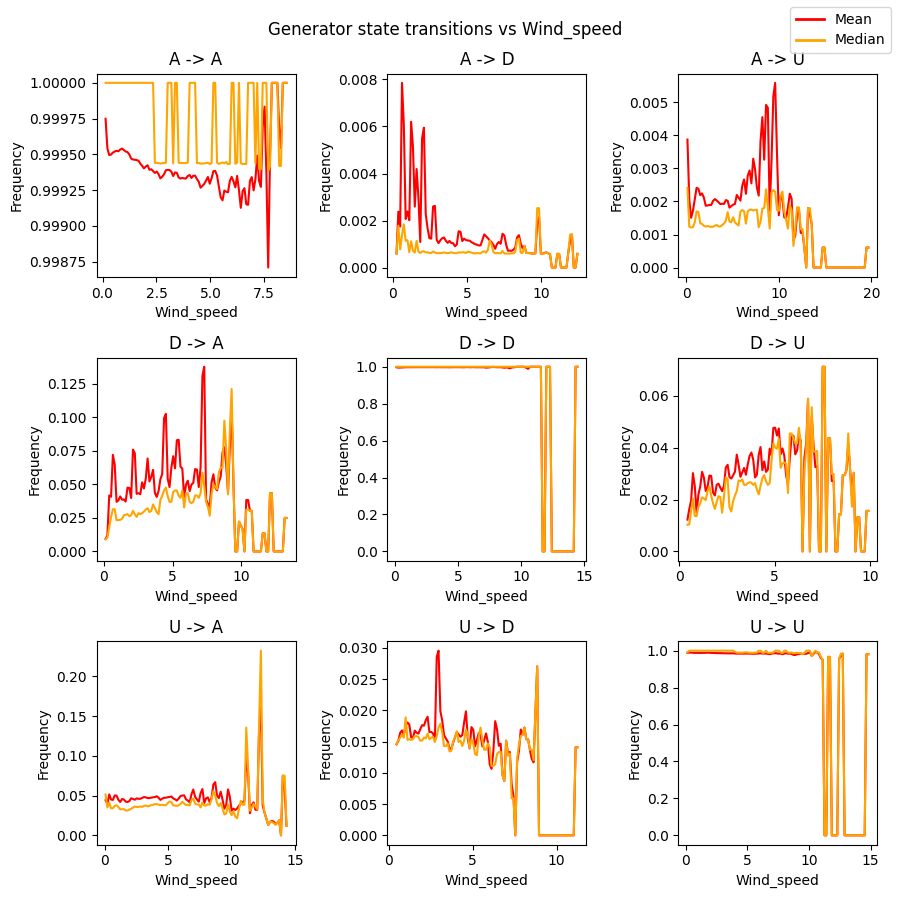

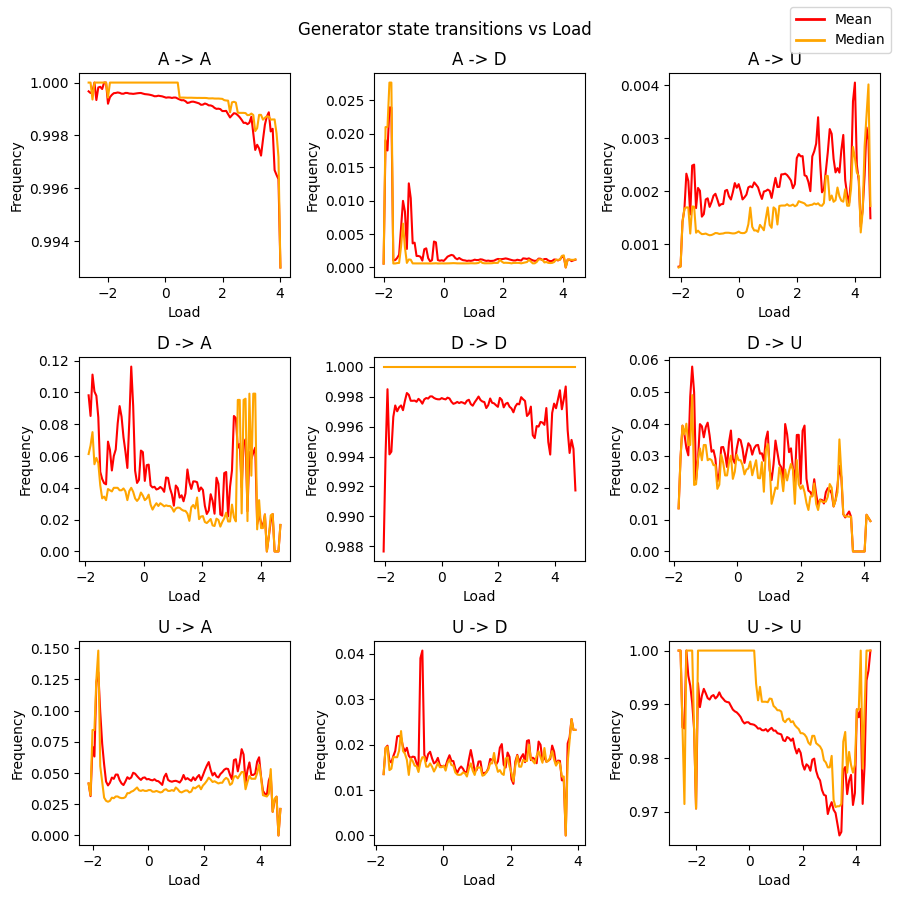

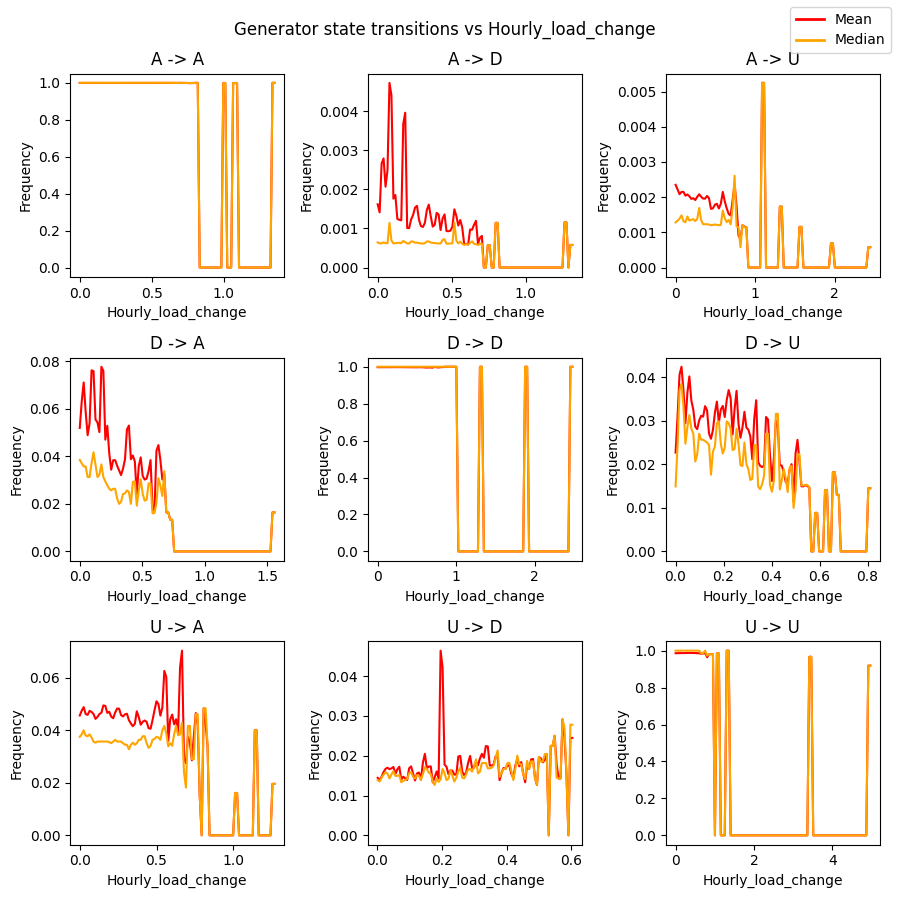

In [39]:
for feature in features_plot:
    plot_state_transition_vs_feature(train_df, feature=feature, x_multiplicator=1)

# Pearson correlation

In [26]:
PB_correlations = defaultdict(lambda: defaultdict(dict))
mic_e = defaultdict(dict)

for initial_state in [0,1,2]:
    subset_df = train_df.loc[train_df['Initial_gen_state']==initial_state]
    # a = subset_df.groupby(['Datetime_UTC', 'Final_gen_state','State']).agg({'Data_weight':'sum', **{feature:'first' for feature in features_plot}}).reset_index()
    # b = subset_df.groupby(['Datetime_UTC','State']).agg({'Data_weight':'sum', **{feature:'first' for feature in features_plot}}).reset_index()
    # count = a.join(b, how='left', on=['Datetime_UTC','State'], lsuffix='_final', rsuffix='_total')
    # count['Freq'] = count['Data_weight_final'] / count['Data_weight_total']
    for end_state in [0,1,2]:
        print(f"{id2state[initial_state]} -> {id2state[end_state]}")
        y = subset_df['Final_gen_state'].values
        w = subset_df['Data_weight'].values
        yg = np.repeat(y, w.astype(int))
        for feature in feature_names:
            x = subset_df[feature].values
            y = np.where(yg == end_state, 1, 0)
            x = np.repeat(x, w.astype(int))
            
            if len(x) > 0 and len(y) > 0:
                # corr = np.corrcoef(x, y)[0,1]
                corr = stats.pointbiserialr(x, y)
                stat, pvalue = corr.statistic, corr.pvalue
                PB_correlations["statistic"][(id2state[initial_state],id2state[end_state])][feature] = stat
                PB_correlations["pvalue"][(id2state[initial_state],id2state[end_state])][feature] = pvalue

                mic = MIC_e(x, y, n_bins=30, strategy='quantile', random_state=42)
                mic_e[(id2state[initial_state],id2state[end_state])][feature] = mic
        

A -> A


/Users/malo/miniconda3/envs/MutualInformation/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


A -> D


/Users/malo/miniconda3/envs/MutualInformation/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


A -> U


/Users/malo/miniconda3/envs/MutualInformation/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


D -> A


/Users/malo/miniconda3/envs/MutualInformation/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


D -> D


/Users/malo/miniconda3/envs/MutualInformation/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


D -> U


/Users/malo/miniconda3/envs/MutualInformation/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


U -> A


/Users/malo/miniconda3/envs/MutualInformation/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


U -> D


/Users/malo/miniconda3/envs/MutualInformation/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


U -> U


/Users/malo/miniconda3/envs/MutualInformation/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


In [32]:
import seaborn as sns

In [28]:
corr = pd.DataFrame(PB_correlations["statistic"])
pval = pd.DataFrame(PB_correlations["pvalue"])
mic_df = pd.DataFrame(mic_e)

Text(0.5, 1.0, 'Point-Biserial Correlation Coefficient between Features and Generator State Transitions')

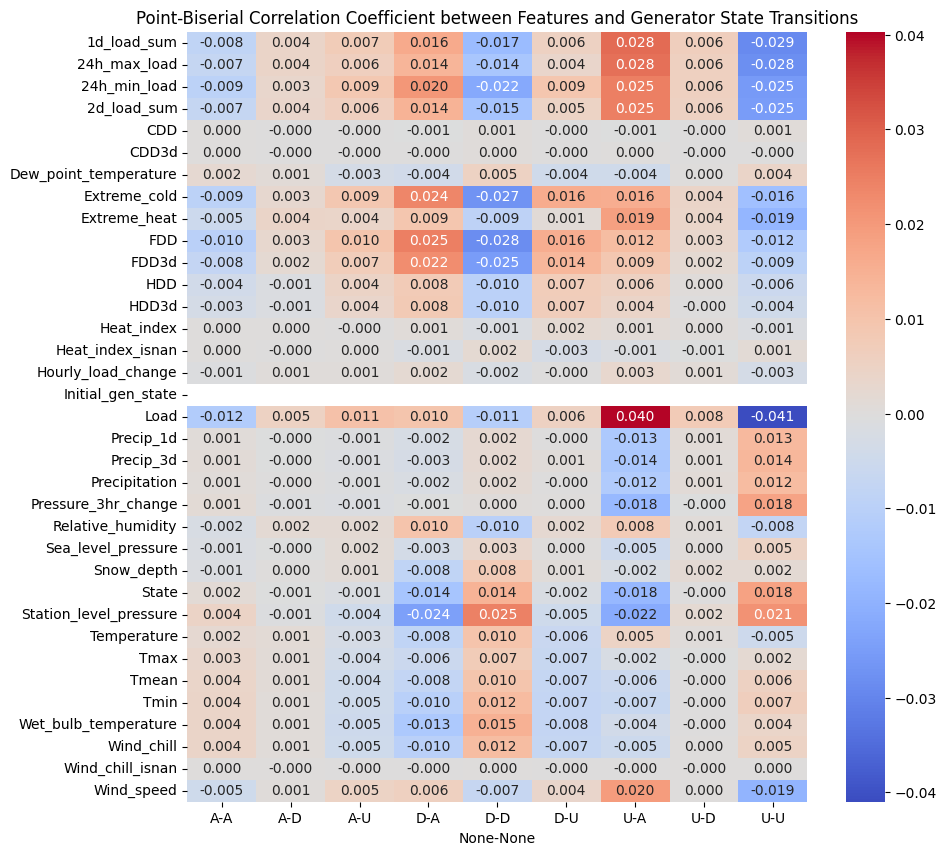

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, annot=True, fmt=".3f", cmap="coolwarm", ax=ax)
ax.set_title("Point-Biserial Correlation Coefficient between Features and Generator State Transitions")

Text(0.5, 1.0, 'P-values of Point-Biserial Correlation Coefficient between Features and Generator State Transitions')

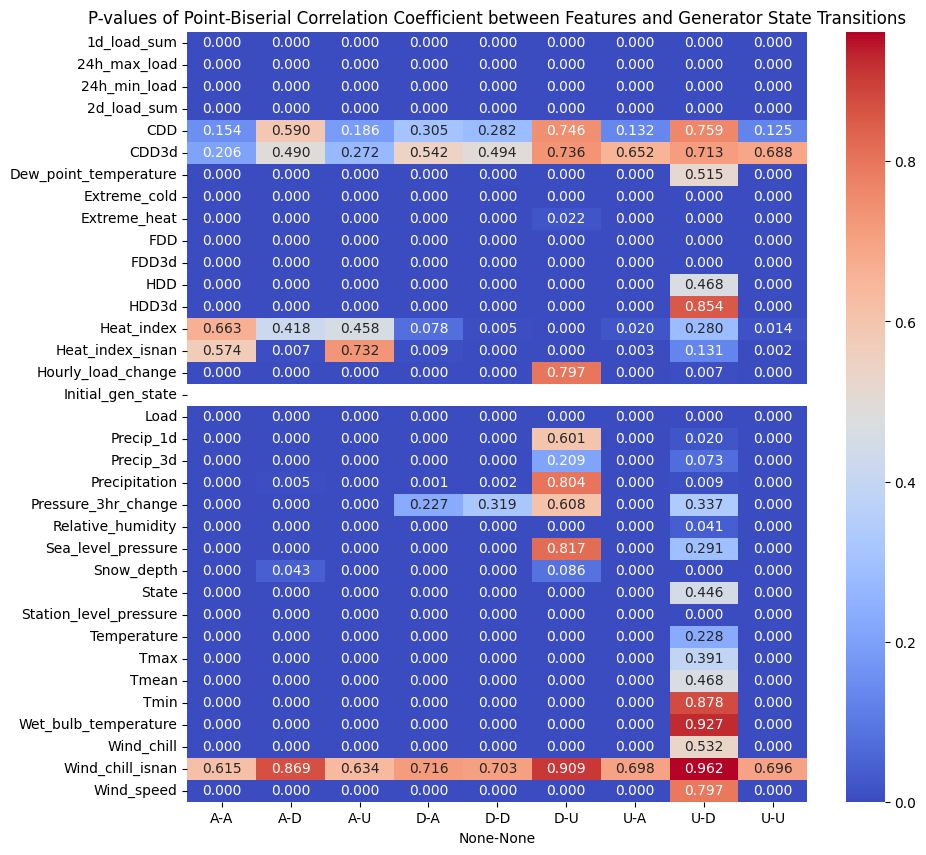

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(pval, annot=True, fmt=".3f", cmap="coolwarm", ax=ax)
ax.set_title("P-values of Point-Biserial Correlation Coefficient between Features and Generator State Transitions")

Text(0.5, 1.0, 'Maximum Information Coefficient between Features and Generator State Transitions')

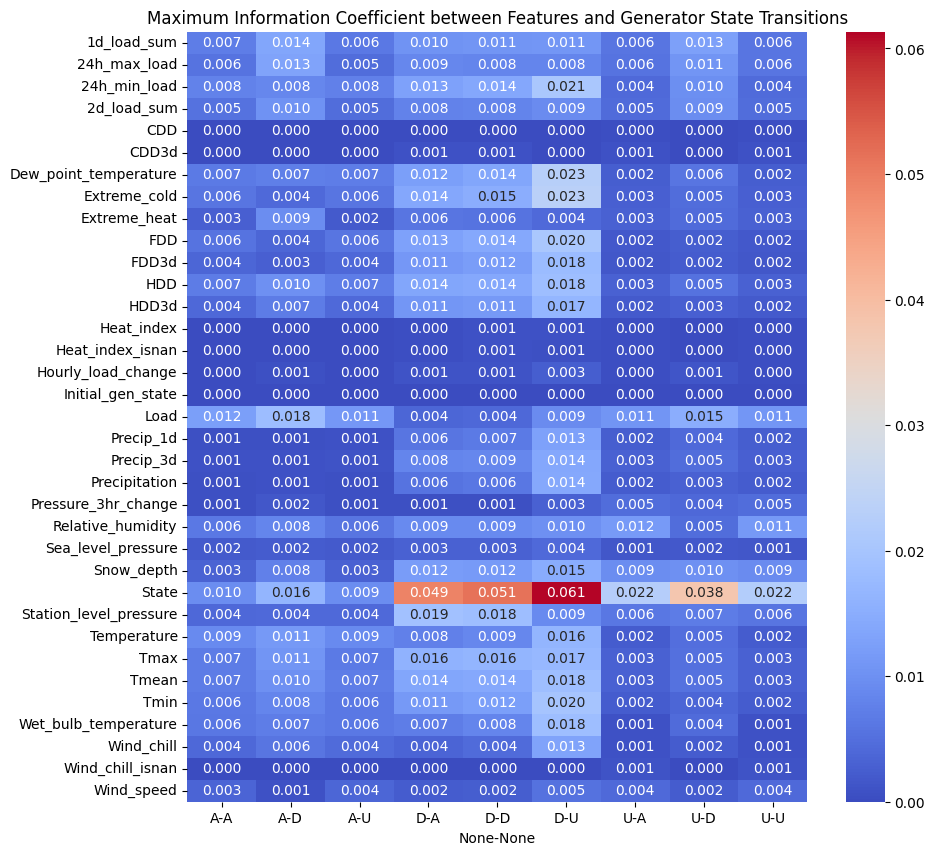

In [36]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(mic_df, annot=True, fmt=".3f", cmap="coolwarm", ax=ax)
ax.set_title("Maximum Information Coefficient between Features and Generator State Transitions")

# Maximum Information Coefficient

In [21]:
def MIC_e(
    x,
    y,
    n_bins: int = 30,
    strategy: str = "quantile",
    random_state: int  = None,
) -> float:
    """
    Approximate MIC_e between a (continuous) feature x and a discrete target y.

    Steps:
    - Drop NaNs from x,y jointly.
    - Normalize x to [0,1].
    - Discretize x into n_bins using quantiles (default) or uniform bins.
    - Compute mutual information I(X_d; Y).
    - Normalize by min(H(X_d), H(Y)) to get a value in [0,1].

    INPUTS
    ------
    x : array-like, shape (N,)
        Continuous feature values.
    y : array-like, shape (N,)
        Discrete labels (e.g., {0,1,2}).
    n_bins : int, default=30
        Number of bins for discretizing x.
    strategy : {"quantile", "uniform"}, default="quantile"
        Binning strategy for x.
    random_state : int | None
        Included for API compatibility (not used here).

    RETURNS
    -------
    mic_e : float in [0,1]
    """
    x = np.asarray(x)
    y = np.asarray(y)

    # --- 0) Basic checks ---
    if x.ndim != 1 or y.ndim != 1:
        raise ValueError("x and y must be 1D arrays.")
    if x.shape[0] != y.shape[0]:
        raise ValueError("x and y must have the same length.")
    n = x.shape[0]
    if n == 0:
        return np.nan

    # --- 1) Drop NaNs jointly ---
    mask = np.isfinite(x) & np.isfinite(y)
    if not mask.any():
        return np.nan
    x = x[mask]
    y = y[mask]
    n = x.shape[0]

    # --- 2) Normalize x to [0,1] ---
    x_min = x.min()
    x_max = x.max()
    denom = x_max - x_min
    if denom <= 0:
        # x is constant => no dependence
        return 0.0
    x_norm = (x - x_min) / (denom + 1e-12)

    # --- 3) Discretize x into bins ---
    if n_bins < 2:
        raise ValueError("n_bins must be >= 2")

    if strategy == "quantile":
        # quantile edges: shape (n_bins+1,)
        q = np.linspace(0.0, 1.0, n_bins + 1)
        edges = np.quantile(x_norm, q)
        # Remove potential duplicates at the boundaries
        # (if many equal values, some quantiles can collapse)
        edges = np.unique(edges)
        # If too many duplicates, fall back to uniform binning
        if edges.size <= 2:
            edges = np.linspace(0.0, 1.0, n_bins + 1)
    elif strategy == "uniform":
        edges = np.linspace(0.0, 1.0, n_bins + 1)
    else:
        raise ValueError("strategy must be 'quantile' or 'uniform'.")

    # digitize returns bins in {1,...,len(edges)-1}
    x_d = np.digitize(x_norm, edges[1:-1], right=True)

    # --- 4) Ensure y is integer-coded (0..C-1) ---
    # (works even if y is already int)
    y_unique, y_inv = np.unique(y, return_inverse=True)
    y_d = y_inv  # 0..C-1
    C = y_unique.shape[0]
    if C < 2:
        # y is constant => no dependence
        return 0.0

    # --- 5) Mutual information I(X_d; Y) ---
    mi = mutual_info_score(x_d, y_d)  # natural log base

    # --- 6) Compute entropies H(X_d), H(Y) for normalization ---
    def _entropy_from_labels(lbl: np.ndarray) -> float:
        vals, counts = np.unique(lbl, return_counts=True)
        p = counts.astype(float) / counts.sum()
        return float(-(p * np.log(p + 1e-12)).sum())

    Hx = _entropy_from_labels(x_d)
    Hy = _entropy_from_labels(y_d)

    # Avoid division by zero
    denom_ent = max(min(Hx, Hy), 1e-12)

    mic = mi / denom_ent

    # Numerical safety: clamp to [0,1]
    if not np.isfinite(mic):
        return np.nan
    mic = max(0.0, min(1.0, mic))
    return mic

In [17]:
x = train_df['Temperature'].values
y = (train_df['Final_gen_state'].values==1).astype(int)

In [23]:
MIC_e(x, y)

np.float64(0.004227638465818768)

In [18]:
print("X dtype:", x.dtype, "min:", x.min(), "max:", x.max(), "unique:", len(np.unique(x)))
print("y dtype:", y.dtype, "unique:", np.unique(y))
print("Any NaN?", np.isnan(x).any(), np.isnan(y).any())

X dtype: float32 min: -3.5690675 max: 4.589582 unique: 3344184
y dtype: int64 unique: [0 1]
Any NaN? False False
